In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

# Stimulus-driven predictive model of brain activity: Joint training

In [1]:
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict, zip_dict
from src.config import *

%matplotlib inline

In [2]:
import torch
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: NVIDIA GeForce RTX 2080

torch: 2.6.0+cu126
cuda:  12.6
cudnn: 90501
dtype: torch.float32


In [3]:
timestamp = time.strftime('%b-%d-%Y_%H%M', time.localtime()) # 'Aug-10-2020_1638' #

model_name = 'anet_fwrf_flex'
model_dir = '%s_%s' % (model_name, timestamp)

output_dir = root_dir+"output/multisubject/%s_%s/" % (model_name,timestamp) 

trn_subjects = [1]
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)   
print ("Time Stamp: %s" % timestamp)

Time Stamp: May-02-2025_1744


# Load the stimuli images
From the subjectwise image preparation

In [4]:
exp_design = loadmat(exp_design_file)
ordering = exp_design['masterordering'].flatten() - 1 # zero-indexed ordering of indices (matlab-like to python-like)

image_data = {}
for s in trn_subjects: 
    image_data_set = h5py.File(stim_dir + "S%d_stimuli_227.h5py"%s, 'r')
    image_data[s] = np.copy(image_data_set['stimuli'])
    image_data_set.close()
    print ('--------  subject %d  -------' % s)
    print ('block size:', image_data[s].shape, ', dtype:', image_data[s].dtype, ', value range:',\
           np.min(image_data[s][0]), np.max(image_data[s][0]))

--------  subject 1  -------
block size: (10000, 3, 227, 227) , dtype: uint8 , value range: 0 255


## Examples

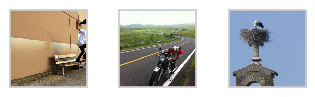

In [5]:
n = 1003
plt.figure(figsize=(4,len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(image_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

# Load the voxel data
- We load a subset (a range of voxels) of all voxel for the sake of the example.

In [6]:
from src.file_utility import load_mask_from_nii, view_data
from src.roi import roi_map, iterate_roi

In [7]:
beta_dir0 = 'C:/Data/nsd/nsddata_betas/ppdata/'

In [8]:
group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]
brain_nii_shape, voxel_mask, voxel_idx, voxel_roi, voxel_ncsnr = {}, {}, {}, {}, {}

for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_vcventral_1.0.nii"%s)
    #voxel_mask_full = load_mask_from_nii(mask_dir + "subj%02d/func1pt8mm/brainmask_nsdgeneral_1.0.nii"%s)
    voxel_roi_full  = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/prf-visualrois.nii.gz"%s)
    voxel_kast_full = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/Kastner2015.nii.gz"%(s))
    general_mask_full  = load_mask_from_nii(mask_dir0 + "subj%02d/func1pt8mm/roi/nsdgeneral.nii.gz"%(s))
    ncsnr_full = load_mask_from_nii(beta_dir0 + "subj%02d/func1pt8mm/betas_fithrf_GLMdenoise_RR/ncsnr.nii.gz"%s)
    ###
    brain_nii_shape[s] = voxel_roi_full.shape
    print (brain_nii_shape[s])
    ###
    voxel_roi_mask_full = (voxel_roi_full>0).flatten().astype(bool)
    voxel_joined_roi_full = np.copy(voxel_kast_full.flatten())  # load kastner rois
    voxel_joined_roi_full[voxel_roi_mask_full] = voxel_roi_full.flatten()[voxel_roi_mask_full] # overwrite with prf rois
    ###
    voxel_mask[s]  = np.nan_to_num(voxel_mask_full).flatten().astype(bool)
    voxel_idx[s]   = np.arange(len(voxel_mask[s]))[voxel_mask[s]]
    voxel_roi[s]   = voxel_joined_roi_full[voxel_mask[s]]
    voxel_ncsnr[s] = ncsnr_full.flatten()[voxel_mask[s]]
    print ('full mask length = %d'%len(voxel_mask[s]))
    print ('selection length = %d'%np.sum(voxel_mask[s]))
    for roi_mask, roi_name in iterate_roi(group, voxel_roi[s], roi_map, group_name=group_names):
        print ("%d \t: %s" % (np.sum(roi_mask), roi_name))

--------  subject 1  -------
(81, 104, 83)
full mask length = 699192
selection length = 4657
1350 	: V1
1433 	: V2
1187 	: V3
687 	: hV4
0 	: V3ab
0 	: LO
0 	: IPS
0 	: VO
0 	: PHC
0 	: MT
0 	: MST
0 	: other


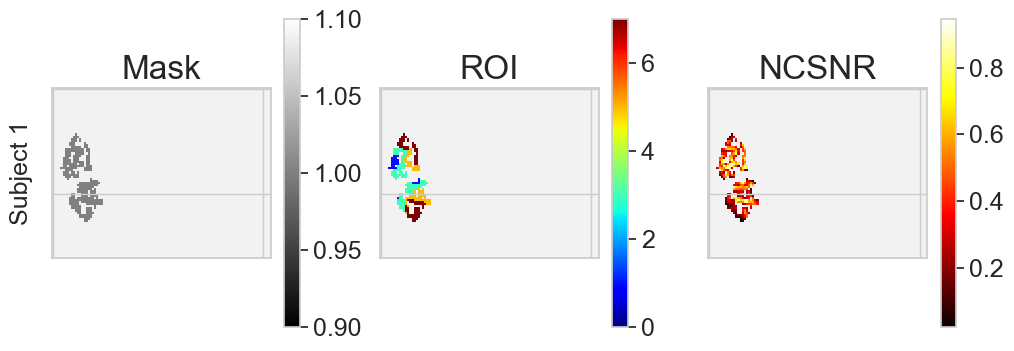

In [9]:
slice_idx = 35
plt.figure(figsize=(12, 4*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    subject_dir = output_dir + 'S%02d/'%s
    if not os.path.exists(subject_dir):
        os.makedirs(subject_dir)
    volume_brain_mask = view_data(brain_nii_shape[s], voxel_idx[s], np.ones_like(voxel_idx[s]), save_to=subject_dir+"subj%02d_mask"%s)
    volume_brain_roi  = view_data(brain_nii_shape[s], voxel_idx[s], voxel_roi[s], save_to=subject_dir+"subj%02d_roi"%s)
    volume_ncsnr      = view_data(brain_nii_shape[s], voxel_idx[s], voxel_ncsnr[s], save_to=subject_dir+"subj%02d_ncsnr"%s) 
    ##
    plt.subplot(len(trn_subjects),3,3*k+1)
    plt.imshow(volume_brain_mask[:,:,slice_idx], cmap='gray', interpolation='None')
    plt.title('Mask')
    plt.colorbar()
    _=plt.ylabel('Subject %d'%s)
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+2)
    plt.imshow(volume_brain_roi[:,:,slice_idx], cmap='jet', interpolation='None')
    plt.clim([0,7])
    plt.title('ROI')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])
    plt.subplot(len(trn_subjects),3,3*k+3)
    plt.imshow(volume_ncsnr[:,:,slice_idx], cmap='hot', interpolation='None')
    plt.title('NCSNR')
    plt.colorbar()
    _=plt.gca().set_xticklabels([])
    _=plt.gca().set_yticklabels([])

# Load voxels
Only run one of these cells
## Quick load (Load the voxel data block for these voxels only)

In [13]:
voxel_data_set = h5py.File(voxel_dir+'voxel_data_general_part1_gnet8j.h5py', 'r')
voxel_data_dict = embed_dict({k: np.copy(d) for k,d in voxel_data_set.items()})
voxel_data_set.close()
voxel_data = {int(k): v for k, v in voxel_data_dict['voxel_data'].items()}

# Dataset split and unpacking or averaging
## Reduce the stimulus set to those of which we have responses so far.
- It just so happens that images with index less than 1000 are shared among subjects and are garanteed not to be shown in the remainder. We therefore chose to reparate our training and validation set along these lines.

In [14]:
from src.load_nsd import image_feature_fn, ordering_split
trn_stim_ordering, trn_voxel_data, val_stim_ordering, val_voxel_data = {},{},{},{}

stim_data = {}
data_size, nnv = {}, {}
for k,s in enumerate(trn_subjects):
    print ('--------  subject %d  -------' % s)
    data_size[s], nnv[s] = voxel_data[s].shape      
    stim_data[s] = image_feature_fn(image_data[s])
    
    trn_stim_ordering[s], trn_voxel_data[s], \
    val_stim_ordering[s], val_voxel_data[s] = \
        ordering_split(voxel_data[s], ordering, combine_trial=False)
    
del image_data
del voxel_data

--------  subject 1  -------
Total number of voxels = 4657


In [15]:
trn_stim_mean = sum([np.mean(stim_data[s], axis=(0,2,3), keepdims=True) for s in trn_subjects])/len(trn_subjects)
print (trn_stim_mean)

[[[[0.47845292]]

  [[0.45531794]]

  [[0.41433865]]]]


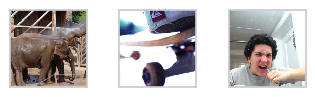

In [16]:
n = 1006
plt.figure(figsize=(4,1*len(trn_subjects)))
for k,s in enumerate(trn_subjects): 
    for i in range(3):
        plt.subplot(len(trn_subjects), 3, 3*k+i+1)
        plt.imshow(stim_data[s][n+i].transpose((1,2,0)), cmap='gray', interpolation='None')
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)

In [17]:
s=1
max_samples = 1000
max_voxels = 2000
val_max_samples = 2000
val_max_voxels = 2000

ordering_subset = {}
voxel_subset = {}
val_ordering_subset = {}
val_voxel_subset = {}

num_samples = min(max_samples, trn_voxel_data[s].shape[0])
num_voxels = min(max_voxels, trn_voxel_data[s].shape[1])
val_num_samples = min(val_max_samples, val_voxel_data[s].shape[0])
val_num_voxels = min(val_max_voxels, val_voxel_data[s].shape[1])

ordering_subset[s] = trn_stim_ordering[s][:num_samples]  
voxel_subset[s] = trn_voxel_data[s][:num_samples, :num_voxels]

val_ordering_subset[s] = val_stim_ordering[s][:val_num_samples] 
val_voxel_subset[s] = val_voxel_data[s][:val_num_samples, :val_num_voxels]

In [18]:
print(stim_data[1].shape)

print('train subset')
print(trn_voxel_data[1].shape)
print(voxel_subset[1].shape)
print(trn_stim_ordering[1].shape)
print(ordering_subset[1].shape)

print('val subset')
print(val_voxel_data[1].shape)
print(val_voxel_subset[1].shape)
print(val_stim_ordering[1].shape)
print(val_ordering_subset[1].shape)
print(stim_data[1].shape)

(10000, 3, 227, 227)
train subset
(27000, 4657)
(1000, 2000)
(27000,)
(1000,)
val subset
(3000, 4657)
(2000, 2000)
(3000,)
(2000,)
(10000, 3, 227, 227)


---
# Model

## Model instanciation

In [20]:
from models.alexnet2 import Alexnet_fmaps_flexible
from src.torch_mpf import *

In [21]:
nnv_subset={s:voxel_subset[s].shape[1] for s in nnv.keys()}
_log_act_fn = lambda _x: T.log(1 + T.abs(_x))*T.tanh(_x)

In [22]:
shared_model = Alexnet_fmaps_flexible(pretrained=True).to(device)

In [23]:
rec, fmaps, h = shared_model(torch.tensor(stim_data[trn_subjects[0]][:100]).to(device))

subject_fwrfs = {s: Torch_LayerwiseFWRF(fmaps, nv=nnv_subset[s], pre_nl=_log_act_fn, \
                 post_nl=_log_act_fn, dtype=np.float32).to(device) for s in trn_subjects}

## Parameter count

In [24]:
for s,sp in subject_fwrfs.items():
    print ("--------- subject %d ----------"%s)
    for p in sp.parameters():
        print ("block size %-16s" % (list(p.size())))
        
param_count = 0
for w in shared_model.parameters():
    param_count += np.prod(tuple(w.size()))
print ('')
print (param_count, "shared params")
total_nv = 0
for s,sp in subject_fwrfs.items():
    for p in sp.parameters():
        param_count += np.prod(tuple(p.size()))
    total_nv += nnv[s]
print (param_count // total_nv, "approx params per voxels")

--------- subject 1 ----------
block size [2000, 13, 13]  
block size [2000, 1, 1]    
block size [2000, 768]     
block size [2000]          

61100846 shared params
13523 approx params per voxels


## Load prefilters value

In [25]:
'''try:
    from torch.hub import load_state_dict_from_url
except ImportError:
    from torch.utils.model_zoo import load_url as load_state_dict_from_url
    
state_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)
        ### Rename dictionary keys to match new breakdown
pre_state_dict = {}
pre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')
pre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')
pre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')
pre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')
  
    
shared_model.pre.load_state_dict(pre_state_dict)
#for s,m in subject_models.items():
#    m.pre.load_state_dict(pre_state_dict)'''

"try:\n    from torch.hub import load_state_dict_from_url\nexcept ImportError:\n    from torch.utils.model_zoo import load_url as load_state_dict_from_url\n    \nstate_dict = load_state_dict_from_url('https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth', progress=True)\n        ### Rename dictionary keys to match new breakdown\npre_state_dict = {}\npre_state_dict['conv1.0.weight'] = state_dict.pop('features.0.weight')\npre_state_dict['conv1.0.bias'] = state_dict.pop('features.0.bias')\npre_state_dict['conv2.0.weight'] = state_dict.pop('features.3.weight')\npre_state_dict['conv2.0.bias'] = state_dict.pop('features.3.bias')\n  \n    \nshared_model.pre.load_state_dict(pre_state_dict)\n#for s,m in subject_models.items():\n#    m.pre.load_state_dict(pre_state_dict)"

## Checkpoint reload

In [26]:
#joined_checkpoint = torch.load(output_dir+'model_params_encft')
#
#best_params = joined_checkpoint['best_params']
#shared_model.load_state_dict(best_params['enc'])
#shared_model.eval() 
#for s,sd in subject_fwrfs.items():
#    sd.load_state_dict(best_params['fwrfs'][s])
#    sd.eval() 

# Loss function, grad function, etc.

In [27]:
optimizer_net = optim.Adam([
       #{'params': shared_model.pre.parameters()},
       {'params': shared_model.parameters()},
   ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08)

subject_optimizer = {s: optim.Adam([
       {'params': sp.parameters()}
   ], lr=1e-3, betas=(0.9, 0.999), eps=1e-08) for s,sp in subject_fwrfs.items()}

#subject_opts = {s: [optimizer_net] for s in subject_optimizer.keys()}
#subject_opts = {s: [subject_optimizer[s]] for s in subject_optimizer.keys()}
subject_opts = {s: [optimizer_net, subject_optimizer[s]] for s in subject_optimizer.keys()}

In [28]:
def _model_fn(_ext, _con, _x):
    '''model consists of an extractor (_ext) and a connection model (_con)'''
    _y, _fm, _h = _ext(_x)
    return _con(_fm)

def _smoothness_loss_fn(_rf, n):
    delta_x = T.sum(T.pow(T.abs(_rf[:, 1:]    - _rf[:, :-1]), n))
    delta_y = T.sum(T.pow(T.abs(_rf[:, :, 1:] - _rf[:, :, :-1]), n))
    return delta_x + delta_y

def vox_loss_fn(r, v, nu=0.5, delta=1.):
    #err = T.sum(huber(r, v, delta), dim=0)
    err = T.sum((r - v)**2, dim=0)
    # squared correlation coefficient with 'leak'
    cr = r - T.mean(r, dim=0, keepdim=True)
    cv = v - T.mean(v, dim=0, keepdim=True)
    wgt = T.clamp(T.pow(T.mean(cr*cv, dim=0), 2) / ((T.mean(cr**2, dim=0)) * (T.mean(cv**2, dim=0)) + 1e-6), min=nu, max=1).detach()
 
    weighted_err = wgt * err # error per voxel
    loss = T.sum(weighted_err) / T.mean(wgt)
    return err, loss
    
def _loss_fn(_ext, _con, _x, _v):
    _r = _model_fn(_ext, _con, _x)
    #_err = T.sum((_r - _v)**2, dim=0)
    #_loss = T.sum(_err)
    _err, _loss = vox_loss_fn(_r, _v, nu=0.1, delta=.5)

    _loss += fpX(1e-1) * T.sum(T.abs(_con.w))
    return _err, _loss
    
    
def _training_fn(_ext, _con, _opts, xb, yb):
    for _opt in _opts:
        _opt.zero_grad()
        _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
        _loss.backward()
        _opt.step()
    return _err

def _holdout_fn(_ext, _con, xb, yb):
    # print (xb.shape, yb.shape)
    _err,_ = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))
    return _err

def _pred_fn(_ext, _con, xb):
    return _model_fn(_ext, _con, T.from_numpy(xb).to(device))

def print_grads(_ext, _con, _params, _opt, xb, yb):
    _opt.zero_grad()
    _err, _loss = _loss_fn(_ext, _con, T.from_numpy(xb).to(device), T.from_numpy(yb).to(device))  
    _loss.backward()   
    for p in _params:
        prg = get_value(p.grad)     
        print ("%-16s : value=%f, grad=%f" % (list(p.size()), np.mean(np.abs(get_value(p))), np.mean(np.abs(prg))))
    print ('--------------------------------------')
    sys.stdout.flush()

# Training
IDEA: Use the more stable estimate from the holdout val cc to weight the voxels
Use a contiguity cost instead of sparsity for RF weights

In [29]:
import src.torch_joint_training_unpacked_sequences as aaa

In [30]:
torch.cuda.empty_cache()
import gc
gc.collect()

1145

In [39]:
from src.torch_joint_training_unpacked_sequences import learn_params_,validation_

In [32]:
batch_size = 100
num_epochs = 20
holdout_frac = .1

best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
    learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
        stim_data, voxel_subset, ordering_subset,
        num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, masks=None, randomize=False)
'''best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score = \
    learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, 
        stim_data, trn_voxel_data, trn_stim_ordering,
        num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, masks=None, randomize=False)'''

subject 1 masked 2000 of 2000
subject 1 training/holdout 900 100
| : 100.0 %
  Epoch 1 of 20 took       3.363s
  training loss:               8.056145
  holdout loss (batch):        5.347929


C:\Codes\nsd_gnet8x-main\src\torch_joint_training_unpacked_sequences.py:129: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_pred = T.tensor(val_pred).to(v.device)  # or keep in torch earlier


  Subject 1: median (max) validation accuracy = 0.091 (0.393)
** Saving params with joint score = 0.091 **

| : 100.0 %
  Epoch 2 of 20 took       3.428s
  training loss:               5.139505
  holdout loss (batch):        4.807516
  Subject 1: median (max) validation accuracy = 0.109 (0.462)
** Saving params with joint score = 0.109 **

| : 100.0 %
  Epoch 3 of 20 took       3.065s
  training loss:               4.553466
  holdout loss (batch):        4.477304
  Subject 1: median (max) validation accuracy = 0.112 (0.458)
** Saving params with joint score = 0.112 **

| : 100.0 %
  Epoch 4 of 20 took       2.996s
  training loss:               4.440531
  holdout loss (batch):        4.463061
  Subject 1: median (max) validation accuracy = 0.106 (0.428)

| : 100.0 %
  Epoch 5 of 20 took       3.007s
  training loss:               4.333164
  holdout loss (batch):        4.421663
  Subject 1: median (max) validation accuracy = 0.107 (0.425)

| : 100.0 %
  Epoch 6 of 20 took       3.010s


'best_params, final_params, hold_cc_hist, hold_hist, trn_hist, best_epoch, best_joint_cc_score =     learn_params_(_training_fn, _holdout_fn, _pred_fn, shared_model, subject_fwrfs, subject_opts, \n        stim_data, trn_voxel_data, trn_stim_ordering,\n        num_epochs=num_epochs, batch_size=batch_size, holdout_frac=holdout_frac, masks=None, randomize=False)'

In [33]:
xb = stim_data[s][:batch_size]
yb = voxel_subset[s][:batch_size]

for _ in range(5):
    _training_fn(shared_model, subject_fwrfs[s], subject_opts[s], xb, yb)
    preds = _pred_fn(shared_model, subject_fwrfs[s], xb).flatten().detach().cpu().numpy()
    corr = np.corrcoef(preds, yb.flatten())[0, 1]
    print("corr: %.4f" % corr)

print('Pred shape:', preds.shape)
print('Target shape:', yb.shape)
print('Pred stats:', np.mean(preds), np.std(preds))
print('Target stats:', np.mean(yb), np.std(yb))

corr: 0.6995
corr: 0.7048
corr: 0.7117
corr: 0.7189
corr: 0.7254
Pred shape: (200000,)
Target shape: (100, 2000)
Pred stats: 1.9610689 2.2854898
Target stats: 1.9339888 2.9746792


In [34]:
shared_model.eval()
sample_x = T.from_numpy(stim_data[trn_subjects[0]][:batch_size]).to(device)
r, fm, h = shared_model(sample_x)

print("Extractor outputs:", r.shape, fm[0].shape, h.shape)
for s in subject_fwrfs:
    preds = subject_fwrfs[s](fm)
    print(f"Subject {s} preds shape:", preds.shape)
    print(preds)

Extractor outputs: torch.Size([100, 3, 227, 227]) torch.Size([100, 512, 13, 13]) torch.Size([100, 4096, 1, 1])
Subject 1 preds shape: torch.Size([100, 2000])
tensor([[ 0.0294, -0.4242,  1.0915,  ...,  0.3855,  0.3192,  0.8469],
        [ 0.0056, -0.4324,  1.0376,  ...,  0.3746,  0.3056,  0.7830],
        [-0.0810, -0.2084,  0.8086,  ...,  0.0610,  0.3367,  0.5827],
        ...,
        [-0.0352, -0.3186,  0.8010,  ..., -0.0302,  0.3873,  0.6786],
        [-0.0918, -0.2971,  0.8648,  ...,  0.1256,  0.3264,  0.6294],
        [ 0.0195, -0.4150,  1.0510,  ...,  0.3419,  0.2894,  0.7421]],
       device='cuda:0', grad_fn=<AddBackward0>)


In [35]:
for s,v in voxel_subset.items():
    mask = np.ones(shape=(v.shape[1]), dtype=bool) 
    #print(mask)

# Results

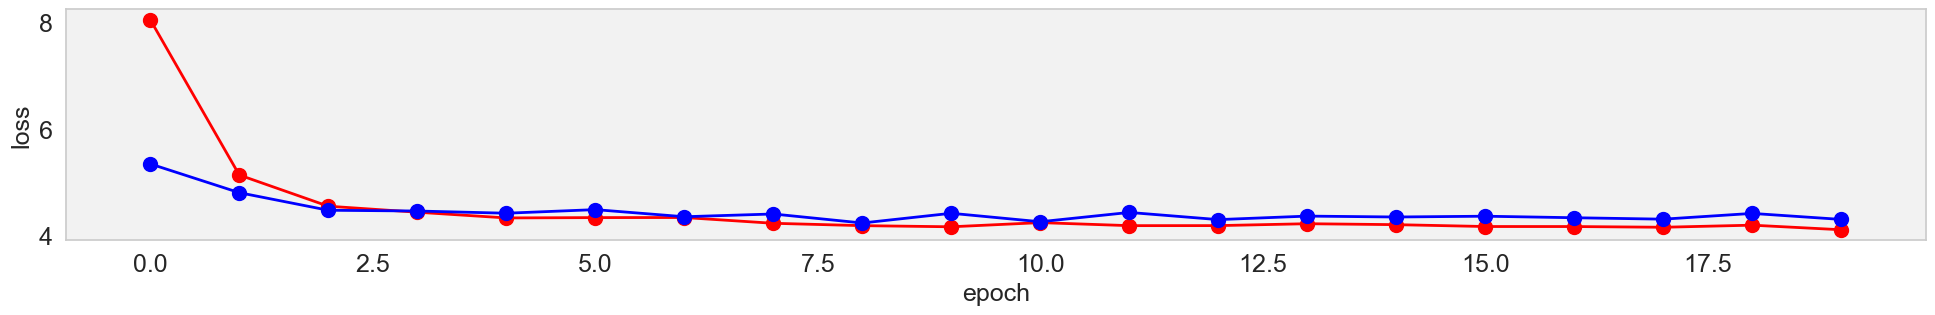

In [36]:
plt.figure(figsize=(24,3))
plt.plot(trn_hist, color='r', marker='o', ms=10, lw=2)
plt.plot(np.array(hold_hist), color='b', marker='o', ms=10, lw=2)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.grid()

C:\Users\jiahaozhang\AppData\Local\Temp\ipykernel_42452\116228997.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


Text(0.5, 0, 'epoch')

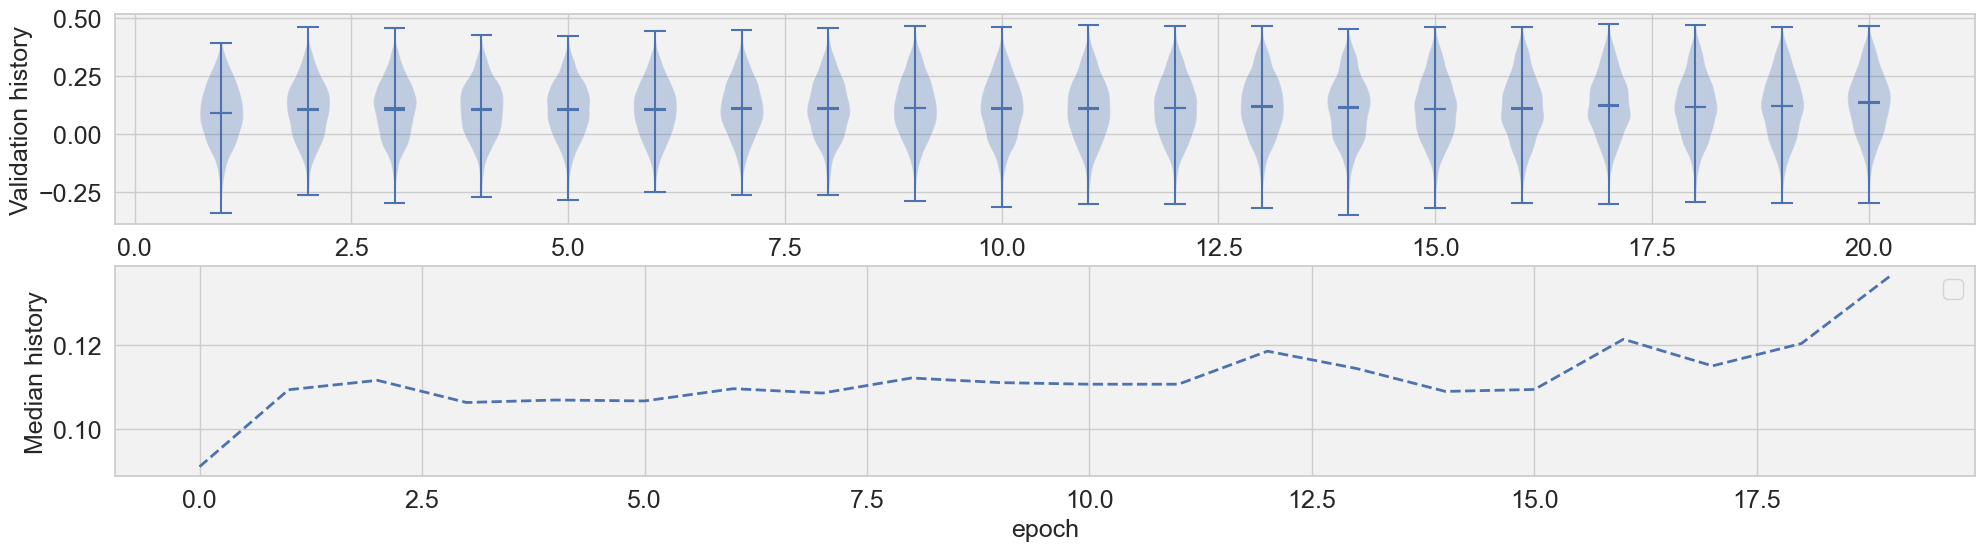

In [37]:
plt.figure(figsize=(24,6))
plt.subplot(2,1,1)
for s,cc in hold_cc_hist.items():
    plt.gca().violinplot(np.nan_to_num(np.array(cc)).T, showmeans=True, showmedians=True, showextrema=True)
plt.ylabel('Validation history')
plt.subplot(2,1,2)
for s in hold_cc_hist.keys():
    p=plt.plot([np.median(cc) for cc in hold_cc_hist[s]], lw=2, linestyle='--')
plt.legend()
plt.ylabel('Median history')
plt.xlabel('epoch')

---
## Final validation accuracy

In [40]:
val_voxel = {s: val_voxel_data[s] for s in val_voxel_data.keys()}
shared_model.load_state_dict(best_params['enc'])
shared_model.eval() 
for s,sd in subject_fwrfs.items():
    sd.load_state_dict(best_params['fwrfs'][s])
    sd.eval() 

batch_size = 100
subject_val_cc = validation_(_pred_fn, shared_model, subject_fwrfs, stim_data, val_voxel_subset, val_ordering_subset, batch_size)
joined_val_cc = np.concatenate(list(subject_val_cc.values()), axis=0)

best joint score = 0.136
best joint val cc = 0.132
subject 1: val cc = 0.132


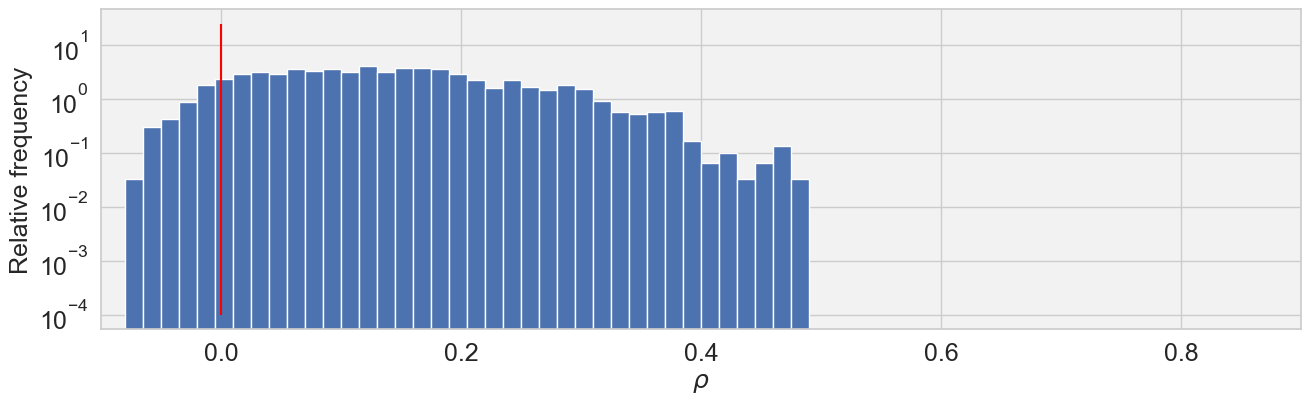

In [41]:
print ("best joint score = %.3f"%best_joint_cc_score)
print ("best joint val cc = %.3f"% np.median(joined_val_cc))
for s,v in subject_val_cc.items():
    print ("subject %s: val cc = %.3f"%(s, np.median(v)))

fig=plt.figure(figsize=(12,4))
plt.subplots_adjust(left=0., bottom=0.2, right=1., top=1., wspace=0., hspace=0.)
_=plt.hist(joined_val_cc, bins=100, density=True, range=(-.5, 1.))
_=plt.vlines(x=[0], ymin=1e-4, ymax=25, color='r')
_=plt.yscale('log')
_=plt.xlim([-.1, 0.9])
_=plt.xlabel(r'$\rho$')
_=plt.ylabel('Relative frequency')

# Save final parameters

In [42]:
torch.save({
            'num_epochs': num_epochs,
            'batch_size': batch_size,
            'holdout_frac': holdout_frac,   
            'best_params': best_params, 
            'final_params': final_params,
            'trn_loss_history': trn_hist,
            'hold_loss_history': hold_hist,
            'hold_cc_history': hold_cc_hist,
            'best_epoch': best_epoch,
            'best_joint_cc_score': best_joint_cc_score,
            'val_cc': subject_val_cc,
            'input_mean': trn_stim_mean,
            'brain_nii_shape': brain_nii_shape,
            'voxel_index': voxel_idx,
            'voxel_roi': voxel_roi,
            'voxel_mask': voxel_mask
            }, output_dir+'model_params_2')

In [43]:
print (output_dir)

C:/Data/nsd_test/output/multisubject/anet_fwrf_flex_May-02-2025_1744/


In [44]:
T.cuda.empty_cache()

In [45]:
gc.collect()

16778